In [1]:
# Notebook para procesar y visualizar la matriz de interacción usuario-producto

# Importar librerías necesarias
from pymongo import MongoClient
import pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import precision_score, recall_score, f1_score
from scipy.sparse import csr_matrix

# Conexión a MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["cross_selling3"]

# Cargar datos desde MongoDB
def load_data():
    interactions = pd.DataFrame(list(db.interactions.find()))
    customers = pd.DataFrame(list(db.customers.find()))
    products = pd.DataFrame(list(db.products.find()))

    if interactions.empty or customers.empty or products.empty:
        raise RuntimeError("No se encontraron datos suficientes en la base de datos.")

    # Asegurarse de que los tipos de datos sean consistentes
    interactions["interaction"] = pd.to_numeric(interactions["interaction"], errors="coerce")
    interactions = interactions.dropna(subset=["interaction"])
    interactions["interaction"] = interactions["interaction"].astype(float)

    # Convertir IDs a cadenas para evitar conflictos de tipo al hacer merge
    interactions["customer_id"] = interactions["customer_id"].astype(str)
    interactions["product_id"] = interactions["product_id"].astype(str)
    customers["_id"] = customers["_id"].astype(str)
    products["_id"] = products["_id"].astype(str)

    return interactions, customers, products

# Unir interacciones con nombres de usuarios y productos
def enrich_data(interactions, customers, products):
    interactions = interactions.merge(customers, left_on="customer_id", right_on="_id", how="left")
    interactions = interactions.merge(products, left_on="product_id", right_on="_id", how="left")
    
    return interactions

# Crear matriz de interacción usuario-producto
def create_interaction_matrix(interactions):
    matrix = interactions.pivot_table(
        index="customer_id", columns="product_id", values="interaction", fill_value=0
    )
    return matrix



In [2]:
# Convertir matriz a formato disperso
def convert_to_sparse_matrix(matrix):
    return csr_matrix(matrix)

# Entrenar modelo KNN
def train_knn_model(sparse_matrix):
    knn_model = NearestNeighbors(metric="cosine", algorithm="brute")
    knn_model.fit(sparse_matrix)
    return knn_model

# Función para evaluar el modelo KNN
def evaluate_knn(interaction_matrix, knn_model, k=5):
    """
    Evalúa el modelo KNN con precisión, recall y F1.
    
    Args:
        interaction_matrix (pd.DataFrame): Matriz de interacciones usuario-producto.
        knn_model: Modelo KNN entrenado.
        k (int): Número de recomendaciones a evaluar.
    
    Returns:
        dict: Métricas de evaluación (Precisión, Recall, F1).
    """
    y_true = []
    y_pred = []

    for user_index in range(interaction_matrix.shape[0]):
        # Obtener vecinos del usuario actual
        distances, indices = knn_model.kneighbors(
            interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=k+1
        )
        
        # Excluir al propio usuario
        similar_users = indices.flatten()[1:]
        
        # Productos relevantes (verdaderos)
        relevant_products = interaction_matrix.iloc[user_index].to_numpy().nonzero()[0]
        
        # Productos recomendados (predichos)
        recommended_products = (
            interaction_matrix.iloc[similar_users]
            .sum(axis=0)
            .sort_values(ascending=False)
            .head(k)
            .index
        )
        
        # Crear listas de verdad y predicción
        y_true.extend([1 if i in relevant_products else 0 for i in range(interaction_matrix.shape[1])])
        y_pred.extend([1 if i in recommended_products else 0 for i in range(interaction_matrix.shape[1])])
    
    # Calcular métricas
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    return {"Precision": precision, "Recall": recall, "F1": f1}

# Ejecución principal
if __name__ == "__main__":
    try:
        print("Cargando datos...")
        interactions, customers, products = load_data()

        print("Enriqueciendo datos...")
        enriched_interactions = enrich_data(interactions, customers, products)

        print("Creando matriz de interacción...")
        interaction_matrix = create_interaction_matrix(enriched_interactions)

        print("Convirtiendo matriz a formato disperso...")
        sparse_matrix = convert_to_sparse_matrix(interaction_matrix)

        print("Entrenando modelo KNN...")
        knn_model = train_knn_model(sparse_matrix)
        print("Modelo KNN entrenado correctamente.")

        print("Evaluando el modelo KNN...")
        metrics = evaluate_knn(interaction_matrix, knn_model, k=5)
        print(f"Evaluación del modelo KNN:\nPrecisión: {metrics['Precision']:.4f}\nRecall: {metrics['Recall']:.4f}\nF1: {metrics['F1']:.4f}")

        print("\nDepuración adicional para verificar resultados")
        print(f"Tamaño de la matriz: {interaction_matrix.shape}")
        print(f"Interacciones totales no nulas: {interaction_matrix.sum().sum()}")
        print(f"Primeras filas de la matriz:\n{interaction_matrix.head()}")

    except Exception as e:
        print(f"Error: {e}")

Cargando datos...
Enriqueciendo datos...
Creando matriz de interacción...
Convirtiendo matriz a formato disperso...
Entrenando modelo KNN...
Modelo KNN entrenado correctamente.
Evaluando el modelo KNN...
Evaluación del modelo KNN:
Precisión: 0.0000
Recall: 0.0000
F1: 0.0000

Depuración adicional para verificar resultados
Tamaño de la matriz: (1000, 500)
Interacciones totales no nulas: 226278.4675
Primeras filas de la matriz:
product_id     1   10   100   101   102   103  104  105  106  107  ...    90  \
customer_id                                                        ...         
1            0.0  0.0  2.02  4.15  0.00  3.97  0.0  0.0  0.0  0.0  ...  2.48   
10           0.0  0.0  0.00  0.00  3.61  0.00  0.0  0.0  0.0  0.0  ...  0.00   
100          0.0  0.0  0.00  3.95  0.00  0.00  0.0  0.0  0.0  0.0  ...  0.00   
1000         0.0  0.0  0.00  3.84  2.16  3.25  0.0  0.0  0.0  0.0  ...  0.00   
101          0.0  0.0  0.00  0.00  0.00  0.00  0.0  0.0  0.0  0.0  ...  0.00   

product_id

In [7]:
# Elegir un usuario aleatorio para probar
user_name = interaction_matrix.index[0]  # Primer usuario en la matriz
print(f"Probando recomendaciones para el usuario: {user_name}")

# Obtener los usuarios similares
user_index = interaction_matrix.index.get_loc(user_name)
distances, indices = knn_model.kneighbors(
    interaction_matrix.iloc[user_index, :].values.reshape(1, -1), n_neighbors=6
)

# Excluir al propio usuario y obtener usuarios similares
similar_users = indices.flatten()[1:]
print(f"Usuarios similares a {user_name}: {interaction_matrix.index[similar_users].tolist()}")
# Recomendar productos basados en usuarios similares
recommended_products = interaction_matrix.iloc[similar_users].sum(axis=0).sort_values(ascending=False)
recommended_products = recommended_products[interaction_matrix.loc[user_name] == 0]

# Mostrar productos recomendados
print(f"Productos recomendados para {user_name}:")
print(recommended_products.head())

# Combinar con los nombres de los productos
recommended_products_df = recommended_products.head().reset_index()
recommended_products_df.columns = ["Producto", "Relevancia"]

print(recommended_products_df)

Probando recomendaciones para el usuario: 1
Usuarios similares a 1: ['864', '29', '929', '365', '502']
Productos recomendados para 1:
product_id
220    10.79
301     9.19
373     9.02
435     9.02
349     9.00
dtype: float64
  Producto  Relevancia
0      220       10.79
1      301        9.19
2      373        9.02
3      435        9.02
4      349        9.00


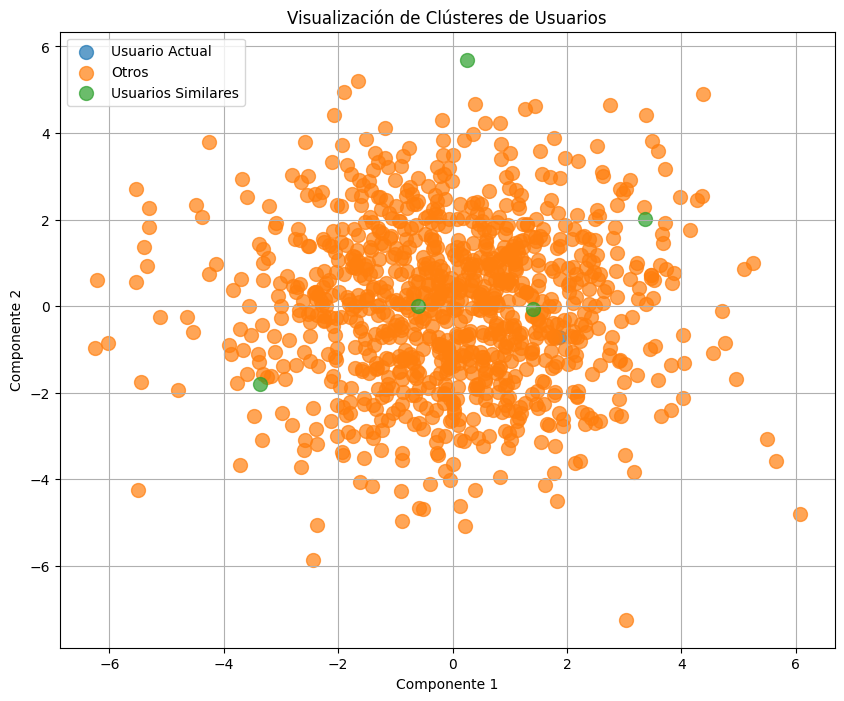

In [9]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd

def plot_all_clusters(interaction_matrix, user_name, similar_users, knn_model):
    # Reducir dimensionalidad con PCA
    pca = PCA(n_components=2)
    reduced_data = pca.fit_transform(interaction_matrix)
    
    # Crear DataFrame para los datos reducidos
    reduced_df = pd.DataFrame(reduced_data, columns=["Componente 1", "Componente 2"], index=interaction_matrix.index)
    reduced_df["Tipo"] = "Otros"
    
    # Identificar el usuario actual y similares
    reduced_df.loc[user_name, "Tipo"] = "Usuario Actual"
    reduced_df.loc[similar_users, "Tipo"] = "Usuarios Similares"
    
    # Generar los clústeres basados en el modelo KNN
    cluster_labels = []
    for i in range(len(interaction_matrix)):
        distances, indices = knn_model.kneighbors(interaction_matrix.iloc[i, :].values.reshape(1, -1), n_neighbors=6)
        cluster_labels.append(indices.flatten()[1:].tolist())
    
    # Agregar los clusters como una columna (opcional para análisis avanzado)
    reduced_df["Cluster"] = cluster_labels
    
    # Graficar todos los usuarios
    plt.figure(figsize=(10, 8))
    for tipo in reduced_df["Tipo"].unique():
        subset = reduced_df[reduced_df["Tipo"] == tipo]
        plt.scatter(subset["Componente 1"], subset["Componente 2"], label=tipo, alpha=0.7, s=100)
    
    # Personalizar gráfico
    plt.title("Visualización de Clústeres de Usuarios")
    plt.xlabel("Componente 1")
    plt.ylabel("Componente 2")
    plt.legend()
    plt.grid(True)
    plt.show()

# Llamar a la función para graficar todos los clústeres
similar_users_names = interaction_matrix.index[similar_users].tolist()
plot_all_clusters(interaction_matrix, user_name, similar_users_names, knn_model)